In [1]:
import spacy as spacy
import torch
from matplotlib import pyplot as plt, ticker
from torchtext.legacy import data

from utils import *
from model import *
from dataloader import *
from transform import TextTransform
from train import train


# load configurations
CONF = load_conf()
# add special characters to config
CONF["special_tokens"] = {
    CONF["unk_token"]: 0,
    CONF["pad_token"]: 1,
    CONF["sos_token"]: 2,
    CONF["eos_token"]: 3,
}

# set seed
set_seed(CONF['seed'])

# get device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# load tokenizers
tokenizer = load_tokenizer(CONF['tokenizer'], 'en')

In [3]:
# from torchtext import datasets
#
# type = 'home'
# QUESTION = data.Field()
# ANSWER = data.Field()
# fields = {'question': ('q', QUESTION), 'answer': ('a', ANSWER)}
#
# train_data, test_data = data.TabularDataset.splits(
#                             path = '../dataset/amazon-qa/'+type,
#                             train = 'train_qa.txt',
#                             test = 'test_qa.txt',
#                             format = 'json',
#                             fields = fields
# )
# print(vars(train_data[0]))
# 构建词表
# `QUESTION.build_vocab(train_data, min_freq=CONF['min_freq'], specials = list(CONF['special_tokens'].keys()))
# ANSWER.build_vocab(train_data, min_freq=CONF['min_freq'], specials = list(CONF['special_tokens'].keys()))`
#
# # 构建迭代器
# train_iterator, test_iterator = data.BucketIterator.splits(
#     (train_data,  test_data),
#     sort = False, #don't sort test/validation data
#     batch_size=CONF['batch_size'],
#     device='cpu'
# )



In [4]:
train_data, test_data = load_amazonqa("../dataset/amazon-qa/home/train_qa.txt", "../dataset/amazon-qa/home/test_qa.txt")

vocab = get_vocab(load_both_iter(train_data), tokenizer, CONF)

transform = TextTransform(tokenizer, vocab, CONF)

train_dataloader = get_dataloader(train_data, transform, transform, CONF)
test_dataloader = get_dataloader(test_data, transform, transform, CONF)

In [5]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()

    # 如果是句子，则分词
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # tokens = [token.lower() for token in sentence]
    tokens = ['<s>'] + tokens + ['</s>']
    # print("tokens: \t", tokens)

    src_indexes = src_field.lookup_indices(tokens)
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = trg_field.lookup_indices(['<s>'])

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)

        pred_token = output.argmax(2)[:, -1].item()
        trg_indexes.append(pred_token)

        if pred_token == trg_field.lookup_indices(['</s>'])[0]:
            break

    trg_tokens = trg_field.lookup_tokens(trg_indexes)
    return trg_tokens[1:], attention


def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(0).cpu().detach().numpy()

    cax = ax.matshow(attention)

    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + ['<s>'] + [t.lower() for t in sentence] + ['</s>'],
                       rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [6]:
convs2s = torch.load("./conv-s2s.pt", map_location=torch.device('cpu'))
convs2s

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(26330, 32)
    (pos_embedding): Embedding(1024, 32)
    (emb2hid): Linear(in_features=32, out_features=32, bias=True)
    (hid2emb): Linear(in_features=32, out_features=32, bias=True)
    (convs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): Decoder(
    (tok_embedding): Embedding(26330, 32)
    (pos_embedding): Embedding(1024, 32)
    (emb2hid): Linear(in_features=32, out_features=32, bias=True)
    (hid2emb): Linear(in_features=32, out_features=32, bias=True)
    (attn_hid2emb): Linear(in_features=32, out_features=32, bias=True)
    (attn_emb2hid): Linear(in_features=32, out_features=32, bias=True)
    (fc_out): Linear(in_features=32, out_features=26330, bias=True)
    (convs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  

In [13]:
# engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
# fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
# for eng, fra in zip(engs, fras):
#     translation, attention_weight_seq = predict_seq2seq(
#         convs2s, eng, src_vocab, tgt_vocab, 10, DEVICE)
#     print(f'{eng} => {translation}')

In [7]:
src = ['a', 'group', 'of', 'people', 'having', 'a', 'barbecue', 'in', 'the', 'park', '.']
tgt = []
translation, attention = translate_sentence(src, vocab, vocab, convs2s, DEVICE)
print(translation)

AssertionError: Torch not compiled with CUDA enabled

D:\Software\Anaconda\envs\torch1.9\lib\site-packages\ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
D:\Software\Anaconda\envs\torch1.9\lib\site-packages\ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


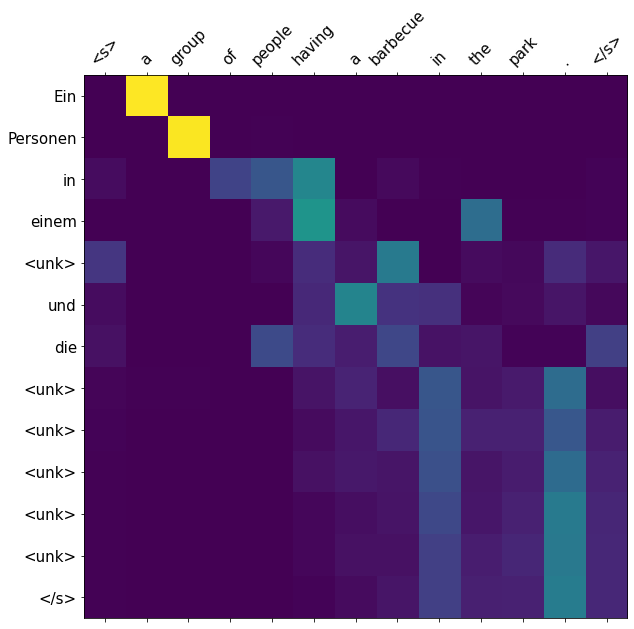

In [17]:
display_attention(src, translation, attention)